## Forecast HSR score

In [1]:
import os, warnings
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())
warnings.filterwarnings('ignore')
os.environ["OMP_NUM_THREADS"] = "1"        # also helps LightGBM avoid thread‐overhead messages

### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# scikit-learn import
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, roc_curve, auc, precision_score, recall_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.combine import SMOTEENN
from lightgbm import LGBMClassifier

### 1. Data Preparation

In [3]:
# Load dataset
df = pd.read_csv('dataset/dataframe.csv')

# peak at the first few row
df.head()

,line,country_id,length,max_speed,cost,success,country,income_level,region,gdp_growth,gdp_total,gdp_pc,rail_km,pop_thousands,pop_density,urban_rate
0,Shanghai maglev train,CHN,30.5,431,1200.0,0.0,China,Upper middle income,East Asia & Pacific,5.249558,17800.0,12614.06174,109767.0,1410710.0,150.420048,64.57
1,Beiging-Shanghai,CHN,1318.0,350,34700.0,1.0,China,Upper middle income,East Asia & Pacific,5.249558,17800.0,12614.06174,109767.0,1410710.0,150.420048,64.57
2,Beijing–Guangzhou,CHN,2230.0,350,42350.0,1.0,China,Upper middle income,East Asia & Pacific,5.249558,17800.0,12614.06174,109767.0,1410710.0,150.420048,64.57
3,Hangzhou–Fuzhou–Shenzhen,CHN,1495.0,350,13312.0,1.0,China,Upper middle income,East Asia & Pacific,5.249558,17800.0,12614.06174,109767.0,1410710.0,150.420048,64.57
4,Huhanrong PDL,CHN,2078.0,350,30400.0,1.0,China,Upper middle income,East Asia & Pacific,5.249558,17800.0,12614.06174,109767.0,1410710.0,150.420048,64.57


In [4]:
# data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   line           160 non-null    object 
 1   country_id     160 non-null    object 
 2   length         160 non-null    float64
 3   max_speed      160 non-null    int64  
 4   cost           160 non-null    float64
 5   success        160 non-null    float64
 6   country        160 non-null    object 
 7   income_level   160 non-null    object 
 8   region         160 non-null    object 
 9   gdp_growth     160 non-null    float64
 10  gdp_total      160 non-null    float64
 11  gdp_pc         160 non-null    float64
 12  rail_km        160 non-null    float64
 13  pop_thousands  160 non-null    float64
 14  pop_density    160 non-null    float64
 15  urban_rate     160 non-null    float64
dtypes: float64(10), int64(1), object(5)
memory usage: 20.1+ KB


In [5]:
# basic stats (numeric and categorical)
df.describe(include='all')

,line,country_id,length,max_speed,cost,success,country,income_level,region,gdp_growth,gdp_total,gdp_pc,rail_km,pop_thousands,pop_density,urban_rate
count,160,160,160.000000,160.000000,160.00000,160.000000,160,160,160,160.000000,160.000000,160.000000,160.000000,1.600000e+02,160.000000,160.000000
unique,160,28,NaN,NaN,NaN,NaN,28,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Shanghai maglev train,DEU,NaN,NaN,NaN,NaN,Germany,High income,Europe & Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,29,NaN,NaN,NaN,NaN,29,140,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,302.169881,250.081250,5869.42125,0.537500,NaN,NaN,NaN,1.390289,3753.722142,44282.382567,26120.301071,1.608318e+05,189.530205,78.953775
std,NaN,NaN,469.154510,52.376956,8866.44196,0.500157,NaN,NaN,NaN,1.771702,5130.330349,20927.069390,30895.486258,3.603403e+05,134.227454,8.856530
min,NaN,NaN,7.700000,160.000000,55.00000,0.000000,NaN,NaN,NaN,-1.163963,81.342661,2849.514611,2025.000000,5.519594e+03,8.807357,50.532000
25%,NaN,NaN,65.600000,200.000000,968.25000,0.000000,NaN,NaN,NaN,-0.266438,885.000000,33509.012800,4962.000000,1.787712e+04,95.572983,74.202000
50%,NaN,NaN,153.750000,245.000000,2603.00000,1.000000,NaN,NaN,NaN,0.936488,2300.000000,44690.934540,16178.560000,5.899347e+04,150.420048,81.456000
75%,NaN,NaN,332.250000,300.000000,6935.50000,1.000000,NaN,NaN,NaN,2.563627,4530.000000,54343.226510,33401.000000,8.328000e+04,239.861418,83.995000


### 2. Exploratory Data Analysis

In [6]:
numeric_features = [
    'length','max_speed','cost',
    'gdp_growth','gdp_total','gdp_pc',
    'rail_km','pop_thousands','pop_density','urban_rate'
]
categorical_features = ['country_id','country','income_level','region']

#### a. Univariate analysis

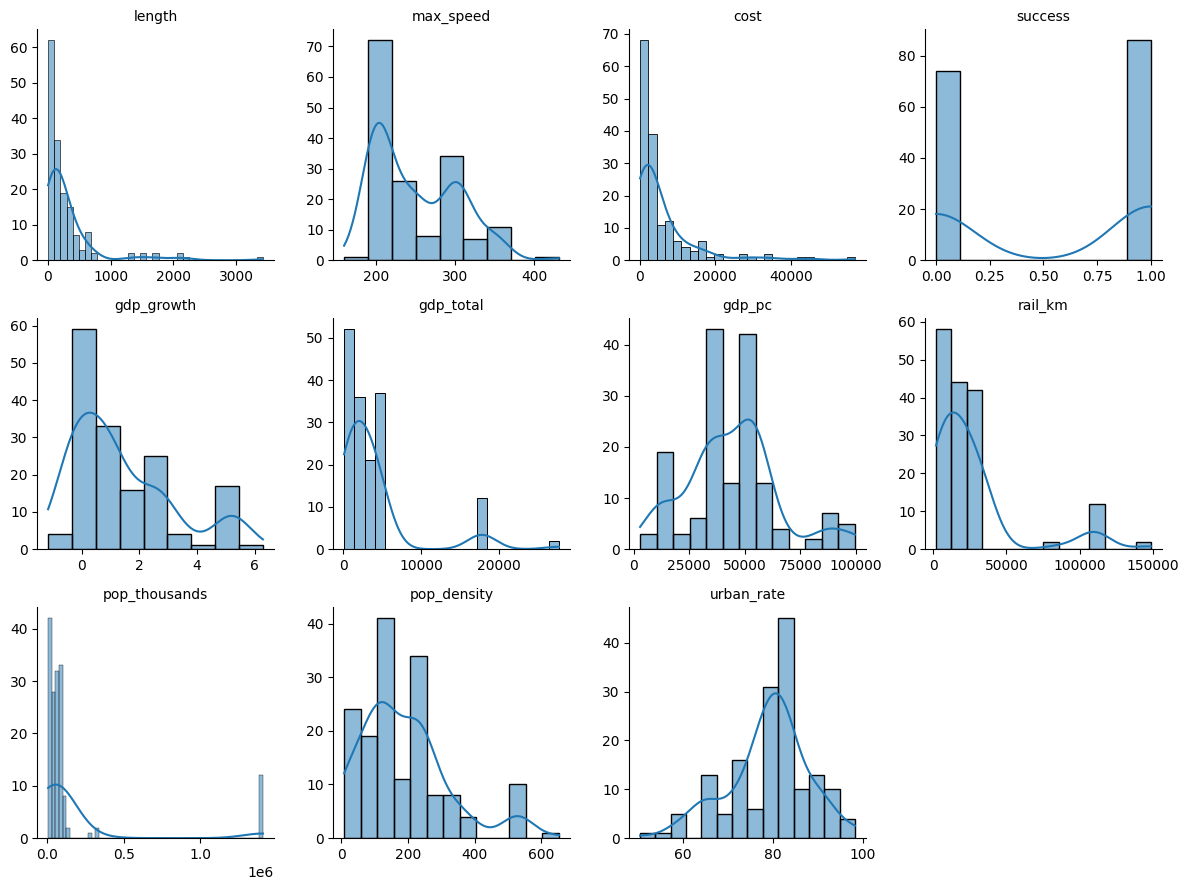

In [7]:
# 1) Melt into long form
num_cols = df.select_dtypes(include="number").columns
melted  = df[num_cols].melt(var_name='feature', value_name='value')

# 2) FacetGrid: one histogram per feature
g = sns.FacetGrid(
    melted,
    col='feature',
    col_wrap=4,       # change 4 to however many plots per row you want
    sharex=False,
    sharey=False
)
g.map(sns.histplot, 'value', kde=True)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
plt.tight_layout()
plt.show()

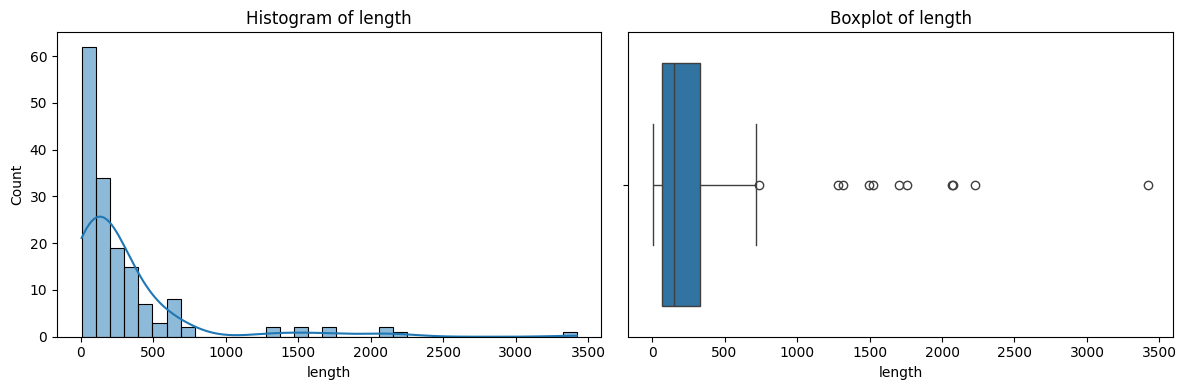

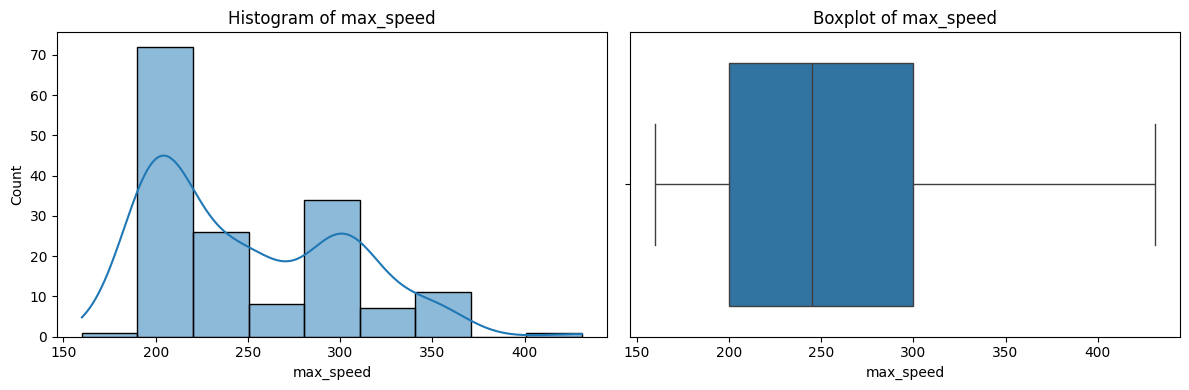

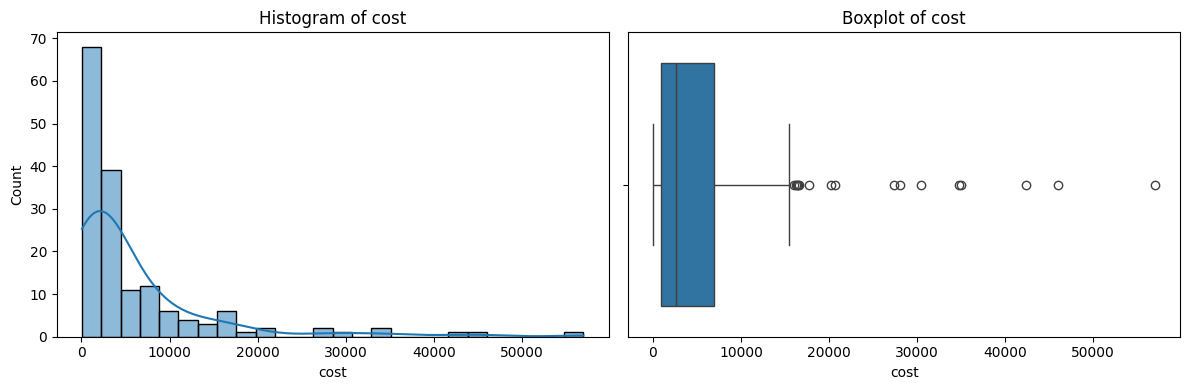

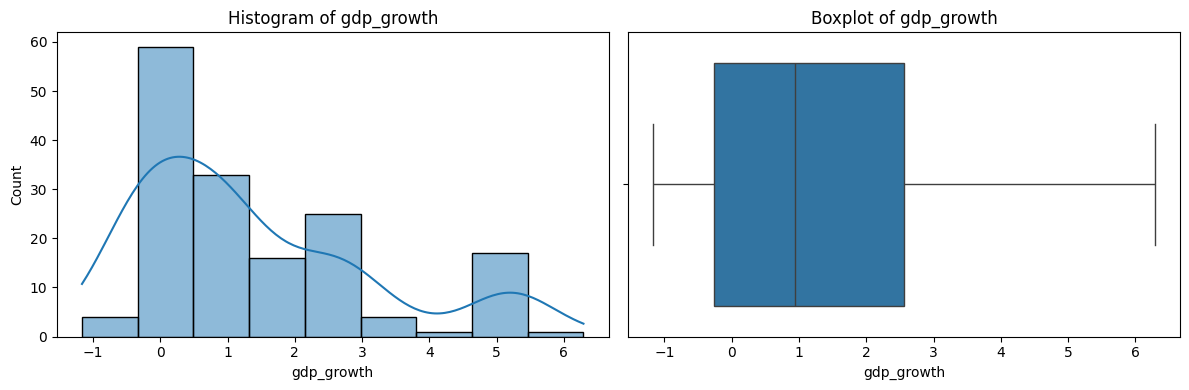

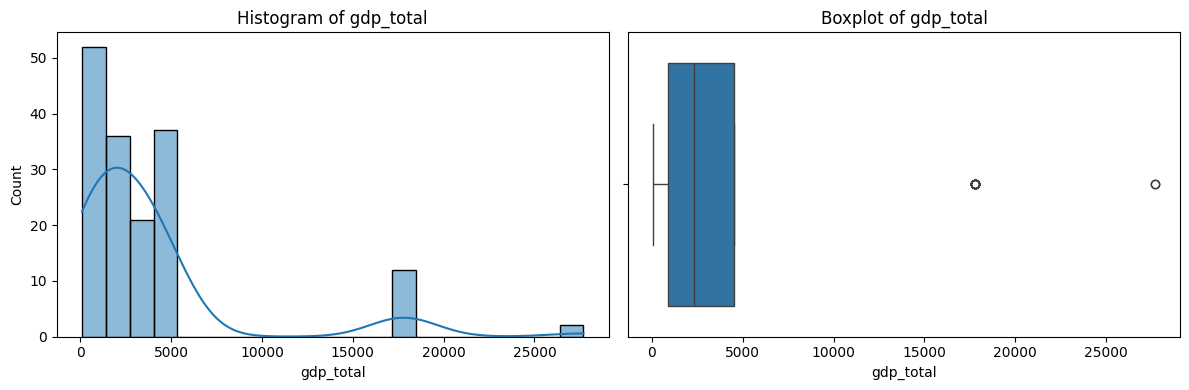

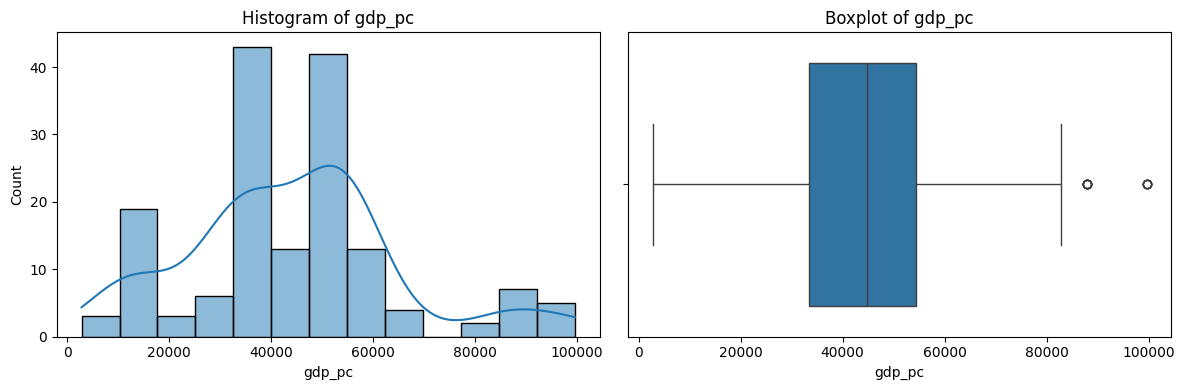

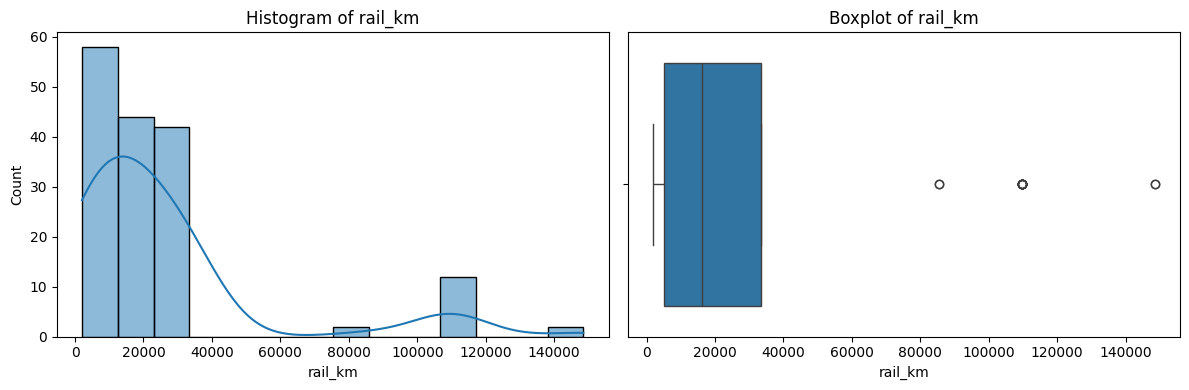

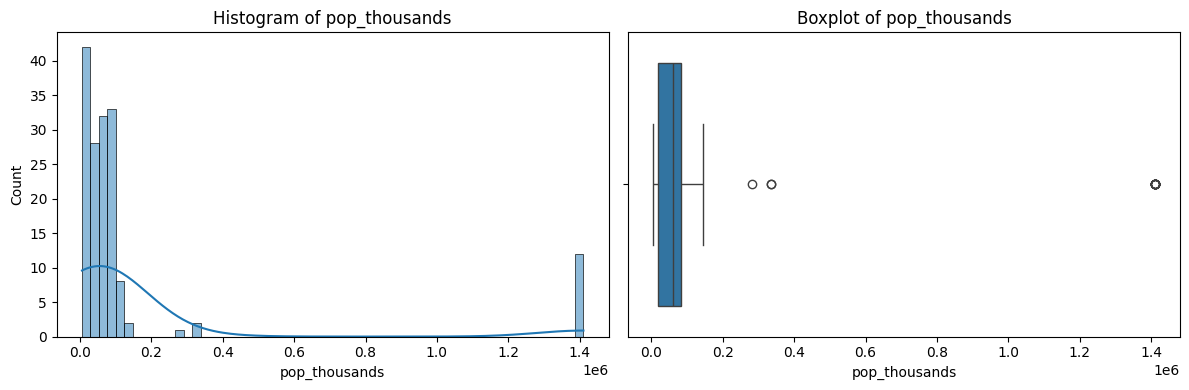

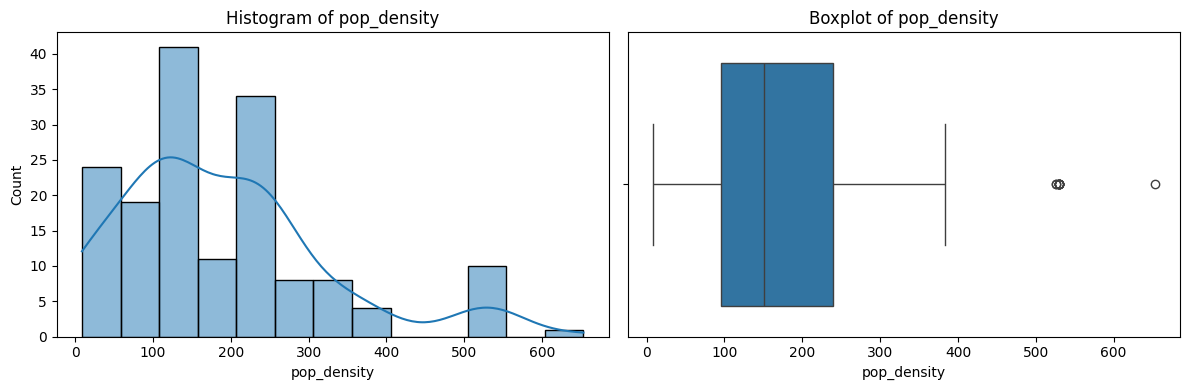

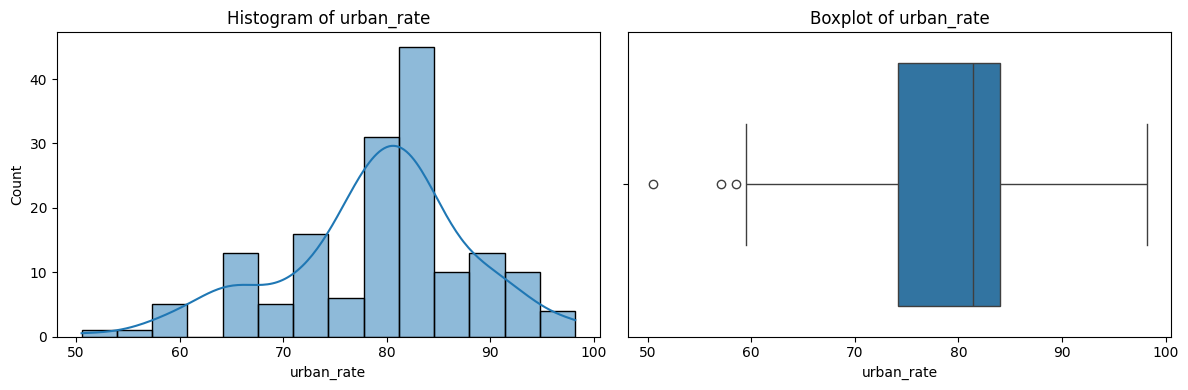

In [8]:
# Numeric features: histograms + boxplots
for col in numeric_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

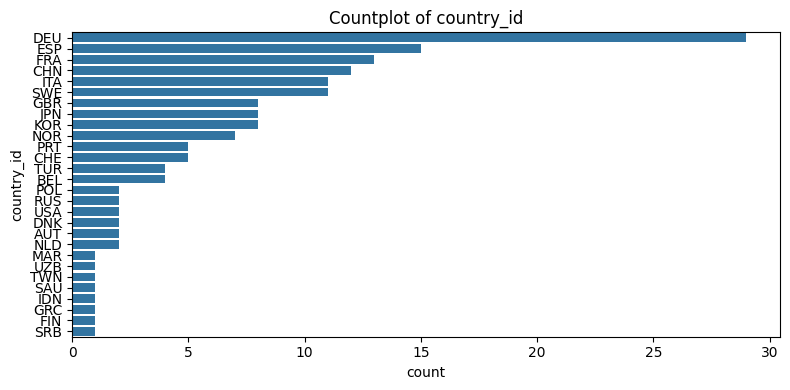

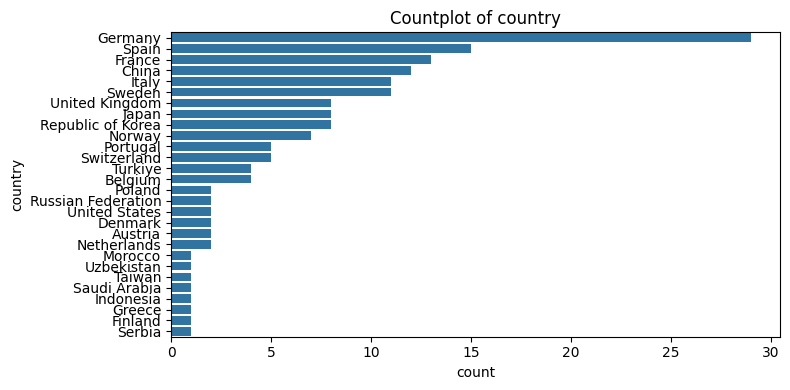

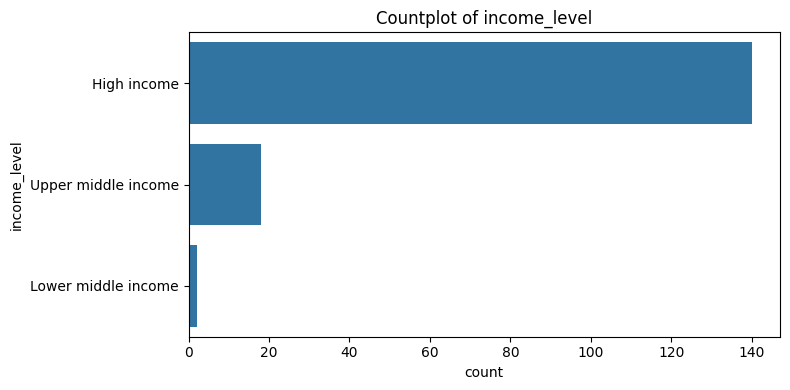

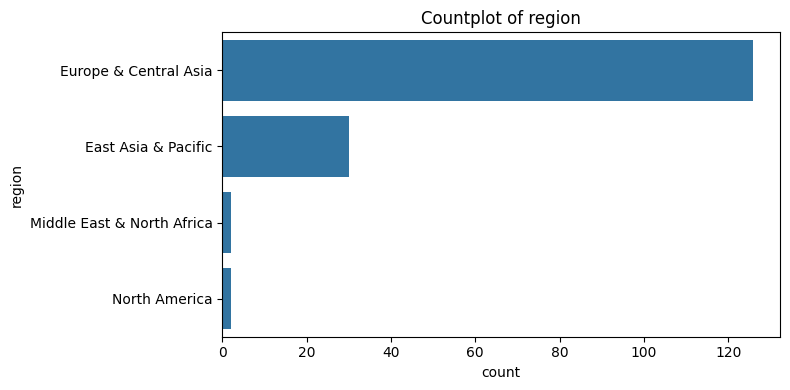

In [9]:
# Categorical features: countplots
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Countplot of {col}')
    plt.tight_layout()
    plt.show()

#### b. Bivariate relationships

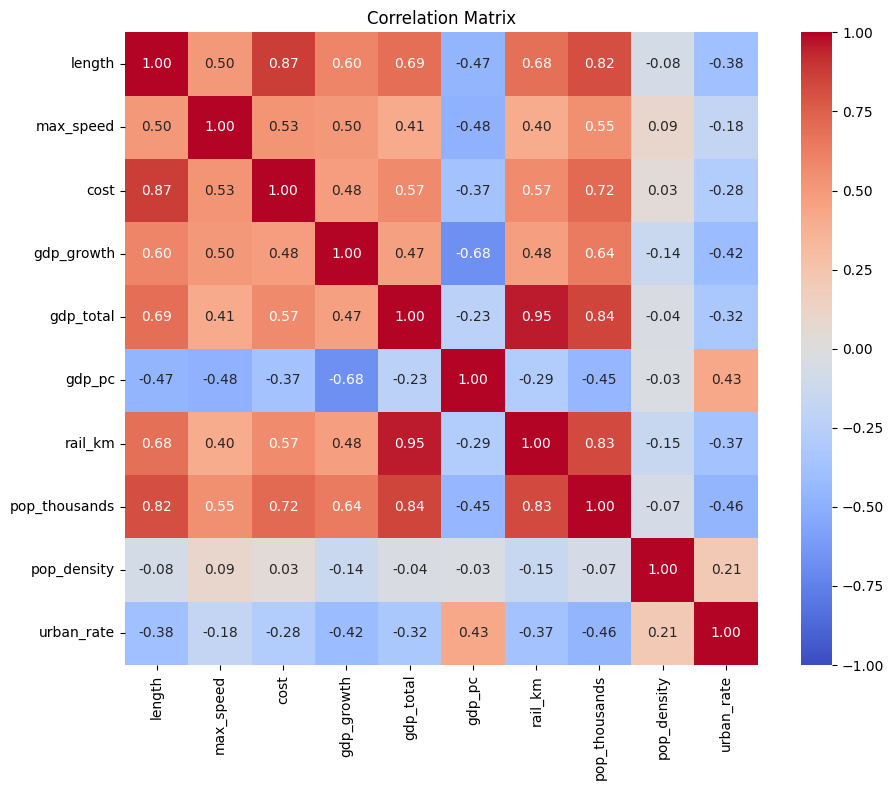

In [10]:
# Correlation matrix for numeric features
plt.figure(figsize=(10, 8))
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmax=1, vmin=-1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

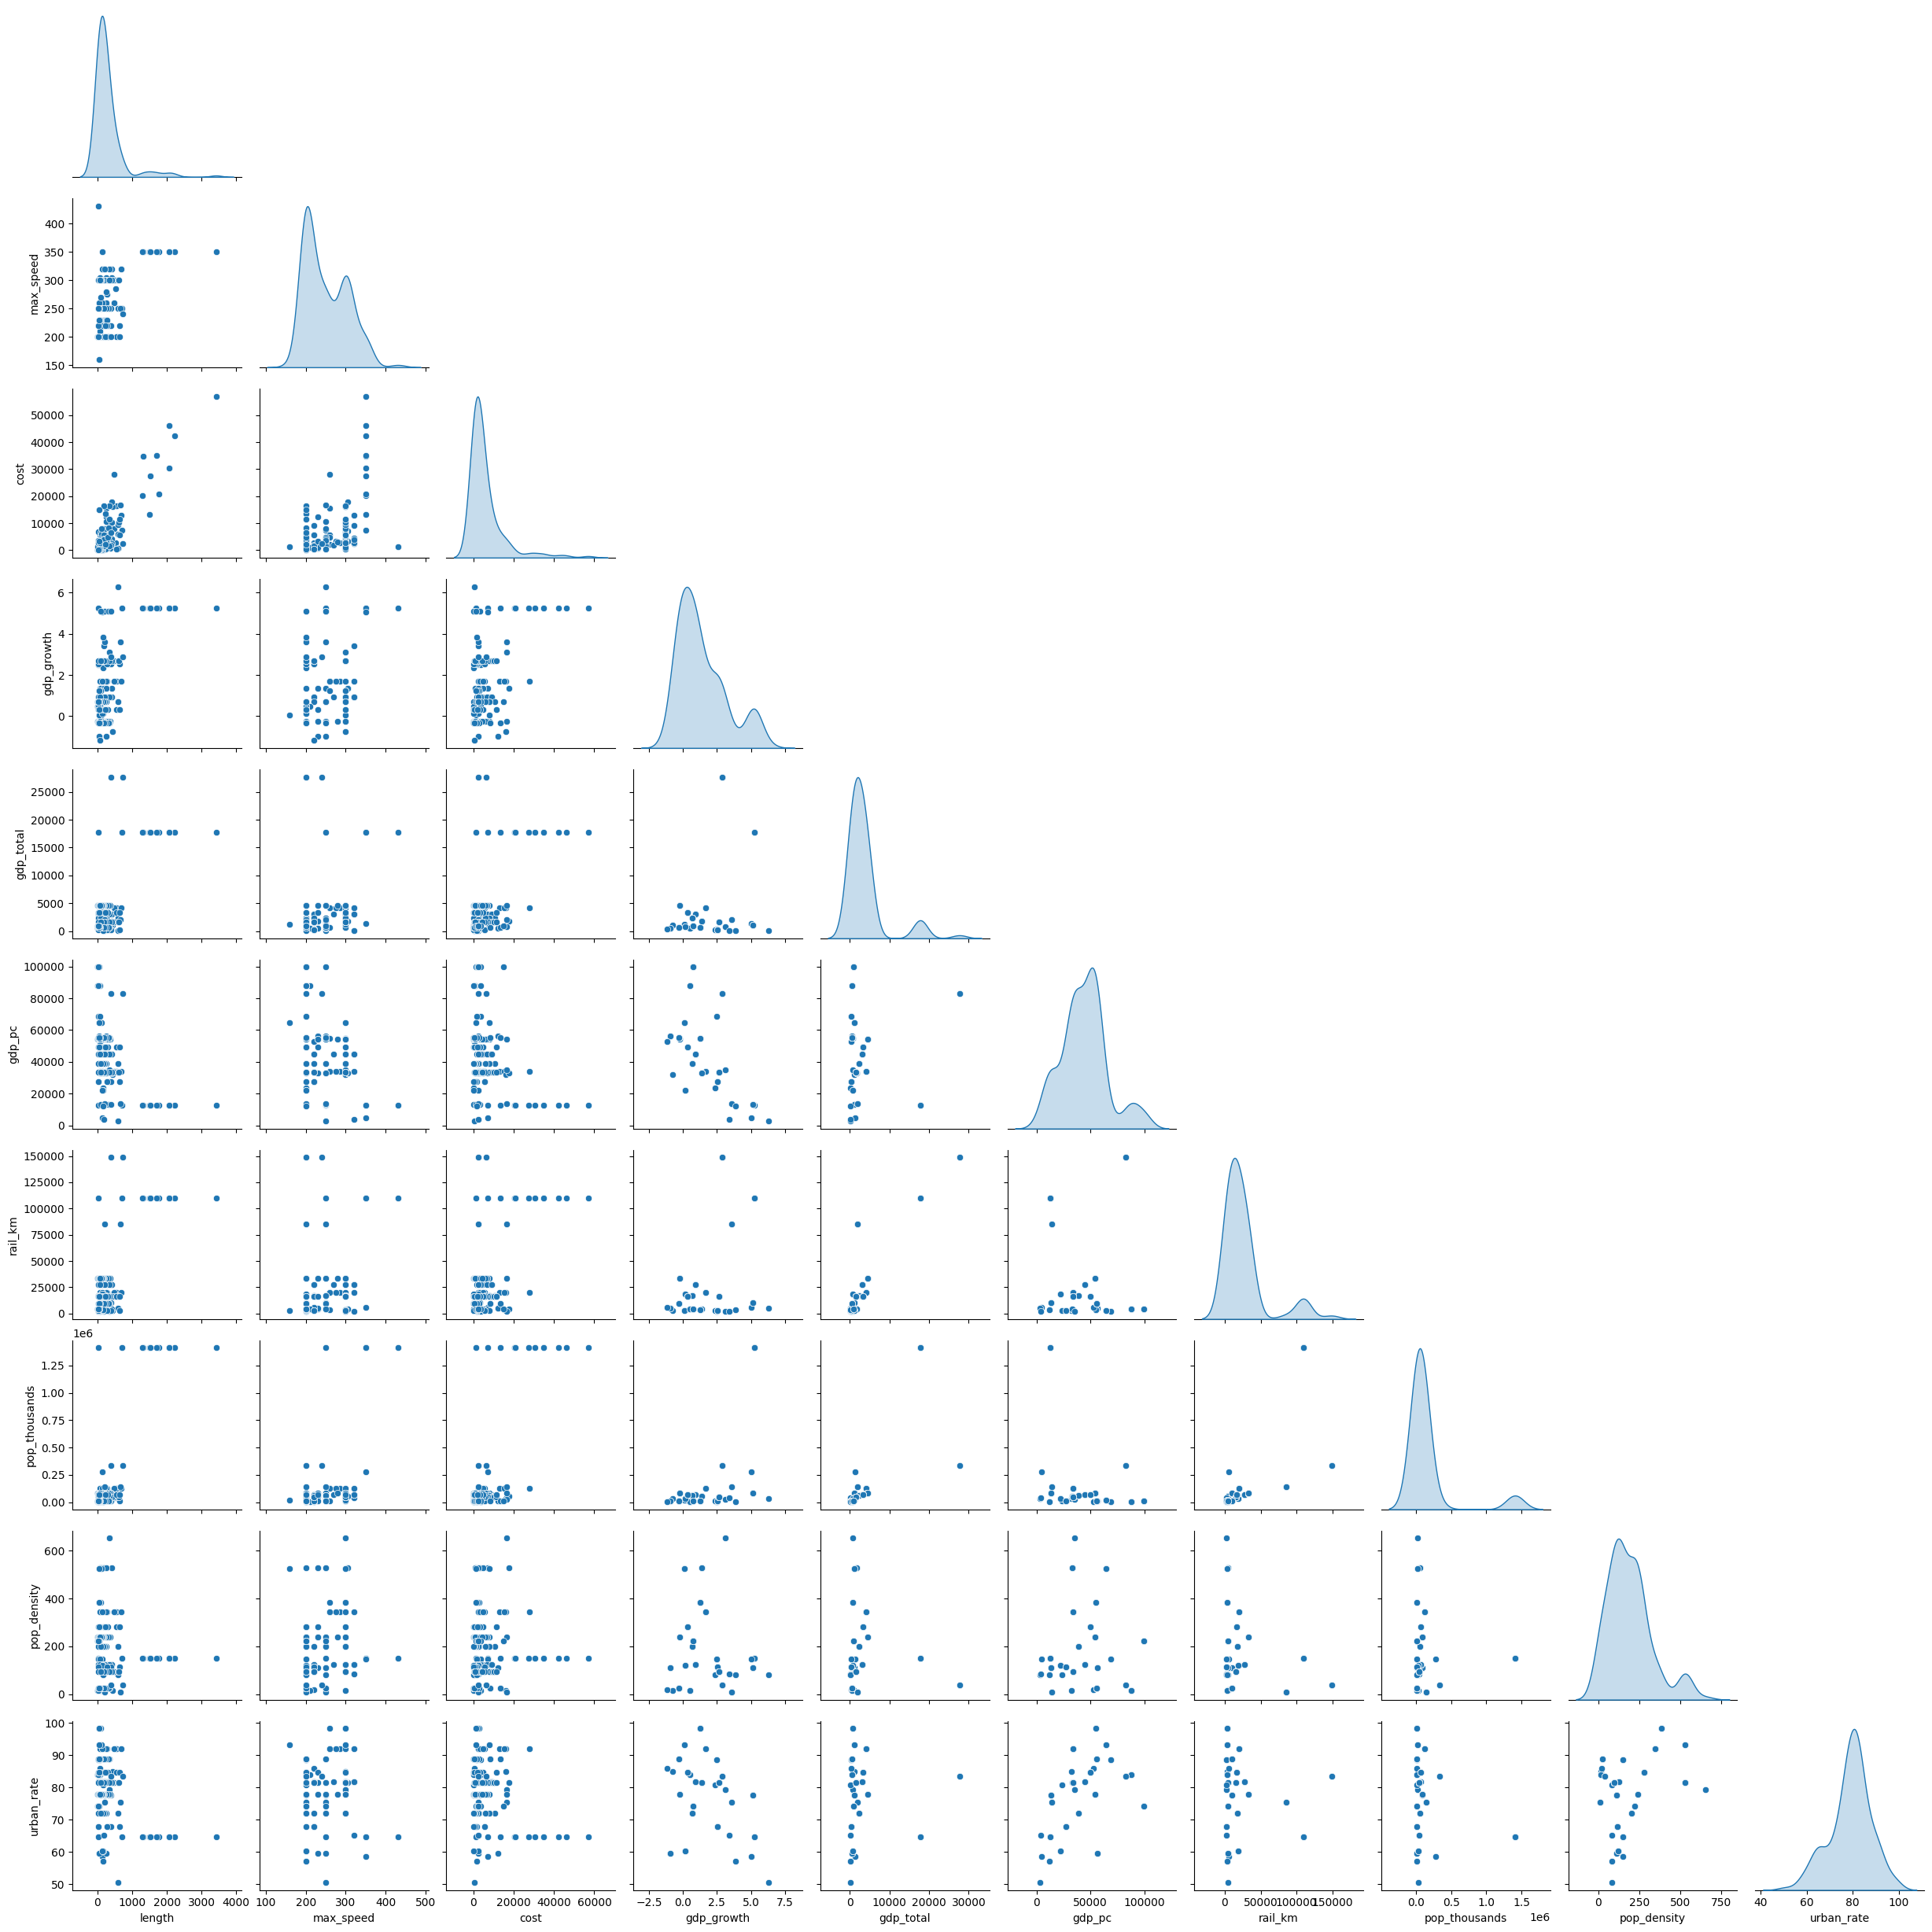

In [11]:
# Pairwise scatter + KDE on the diagonal
sns.pairplot(df[numeric_features], diag_kind='kde', corner=True)
plt.show()

#### c. Target vs. features

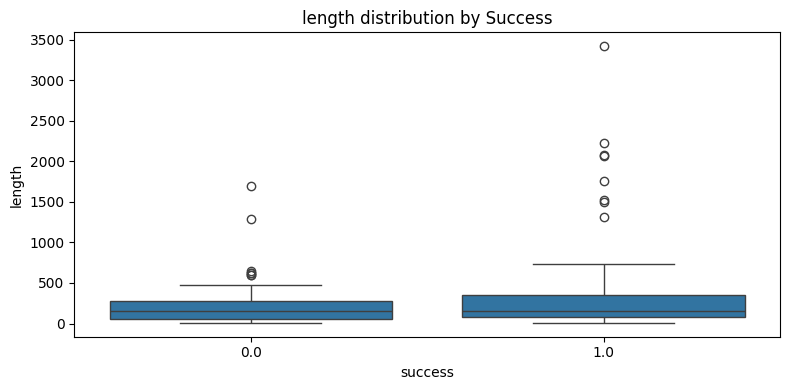

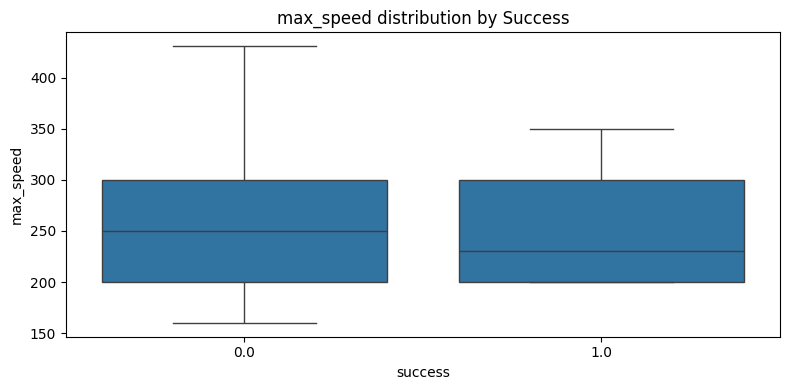

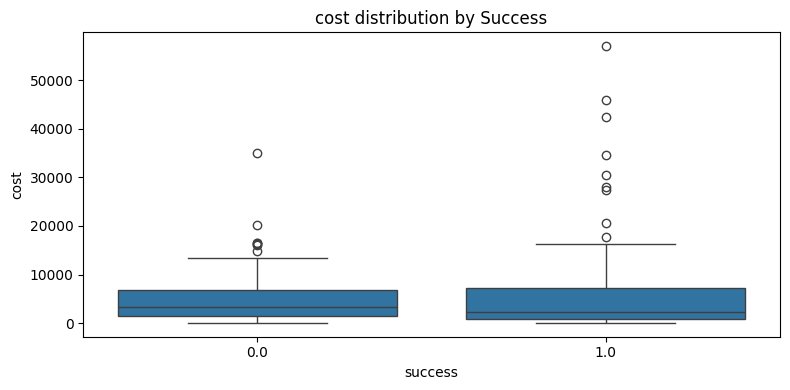

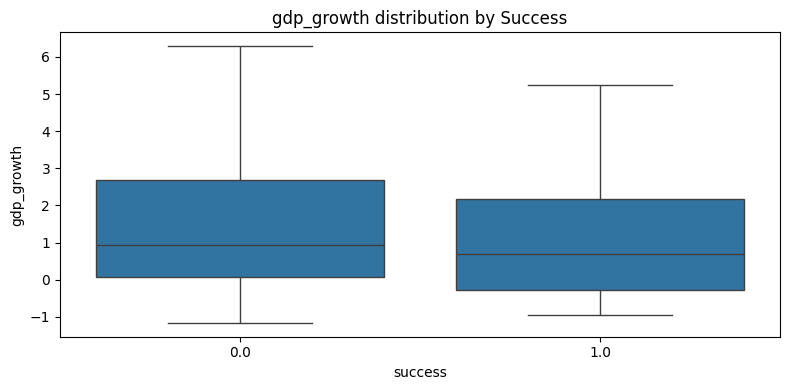

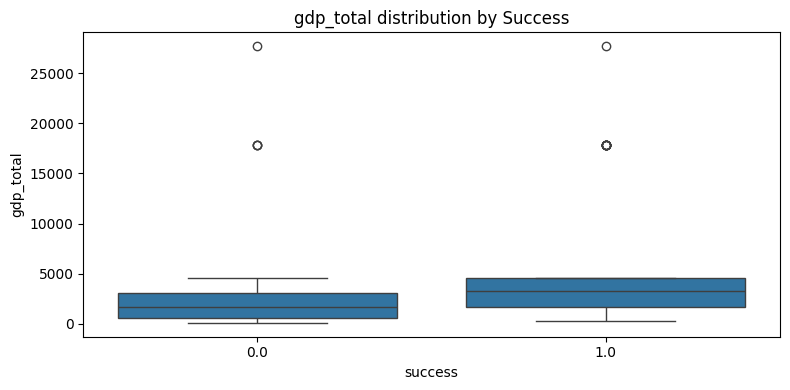

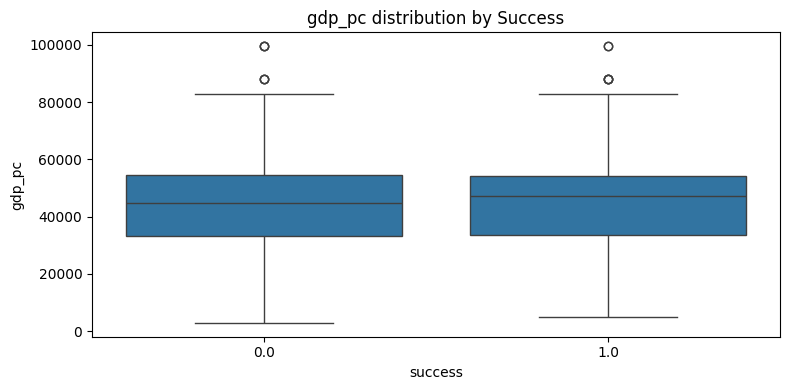

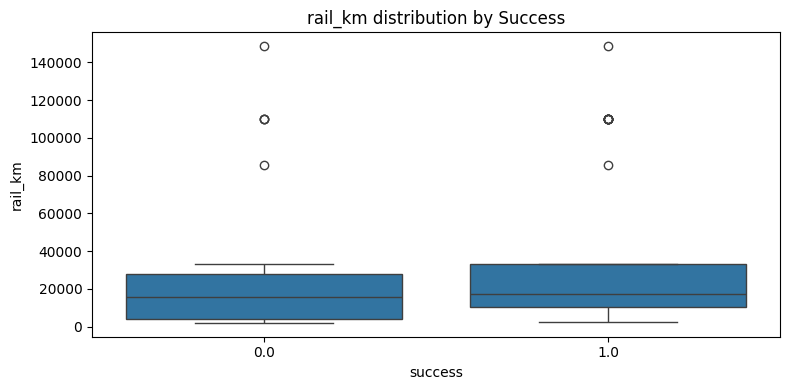

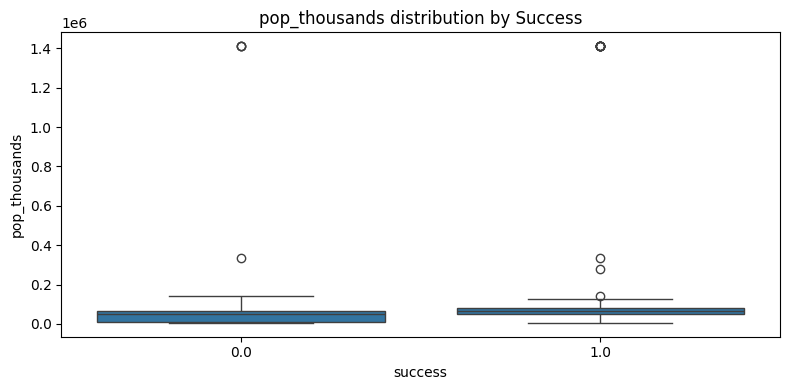

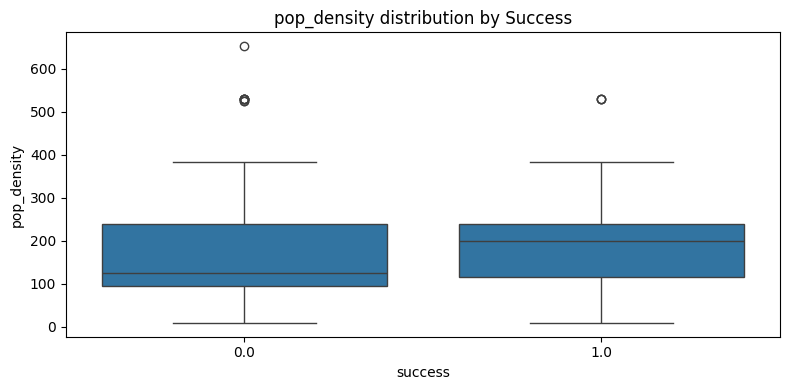

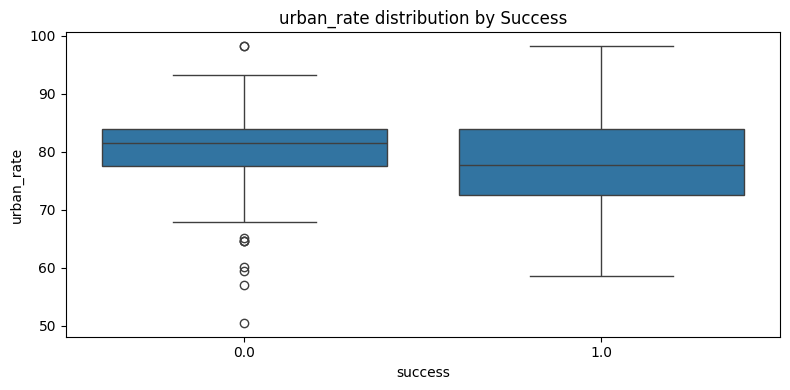

In [12]:
# Numeric features by target
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='success', y=col, data=df)
    plt.title(f'{col} distribution by Success')
    plt.tight_layout()
    plt.show()

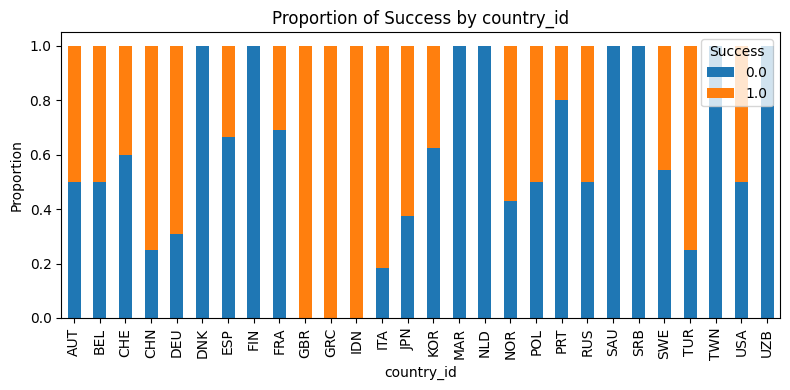

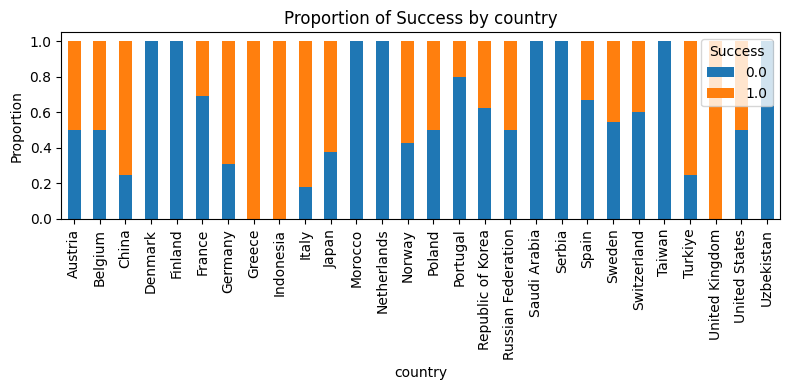

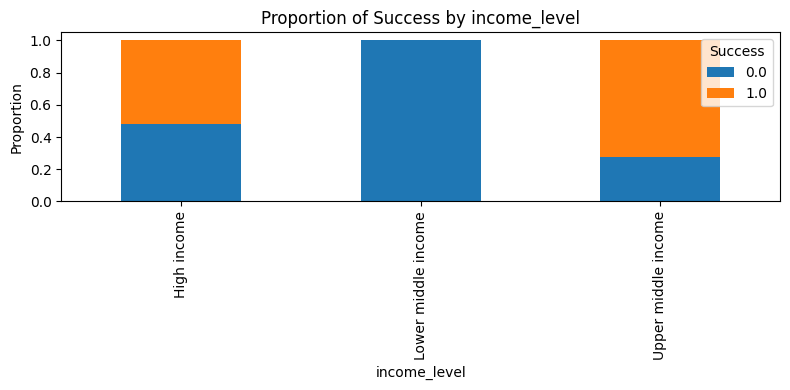

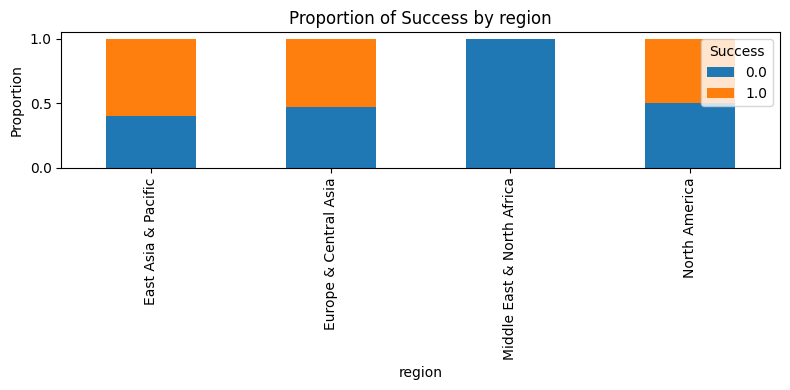

In [13]:
# Categorical features vs. target: stacked bar (proportions)
for col in categorical_features:
    prop = (
        df
        .groupby([col, 'success'])
        .size()
        .unstack(fill_value=0)
        .pipe(lambda d: d.div(d.sum(axis=1), axis=0))
    )
    prop.plot(
        kind='bar', 
        stacked=True, 
        figsize=(8, 4),
        legend=True
    )
    plt.ylabel('Proportion')
    plt.title(f'Proportion of Success by {col}')
    plt.legend(title='Success', loc='upper right')
    plt.tight_layout()
    plt.show()

##### Insight

1. Univariate distribution

- Length and cost are highly right-skewed, with a long tail of very long/very expensive lines $\Rightarrow$ may be need to log-transform these to tame outliers.
- Max speed clusters around a few discrete values (200, 250, 300, 350, 431 km/h) $\Rightarrow$ it may act more like a categorical or ordinal variable than continuous.
- GDP nad population metrics also show heavy skew $\Rightarrow$ log scaling before modeling.

2. Categorial breakdowns

- We may drop the countries and regions columns, since it doesn't match our model's purpose of prediction.

3. Pairwise and target relationships

- Cost vs length and gdp_total are extremely highly correlated $\Rightarrow$ may drop or combine one of each pair to reduct multicollinearity.
- In the success vs feature boxplots, succesful lines tend to have higher median cost per km and higher urban_rate, while very short or very low-cost lines rarely succeed.

### 3. Feature engineering and selection

#### a. Feature engineering

In [14]:
# log-transform skewed numeric columns
for col in ['length','cost','gdp_total','pop_thousands','rail_km']:
    df[f'log_{col}'] = np.log1p(df[col])

In [15]:
# ratio / interaction features
df['cost_per_km']         = df['cost'] / df['length']
df['speed_to_cost']       = df['max_speed'] / df['cost']
df['density_interaction'] = df['gdp_pc'] * df['pop_density']

In [16]:
# length bins
df['length_bin'] = pd.cut(
    df['length'],
    bins=[0, 100, 500, np.inf],
    labels=['short','medium','long']
)

In [17]:
# remove country/region columns entirely
# (nothing to do here since we simply won't include them downstream)

In [18]:
# map income_level to ordinal if it exists
if 'income_level' in df.columns:
    ord_map = {'Low income':0,'Lower middle income':1,'Upper middle income':2,'High income':3}
    df['income_level'] = df['income_level'].map(ord_map)

#### b. Define features and target

In [19]:
numeric_features = [
    'max_speed','gdp_growth','gdp_pc','pop_density','urban_rate',
    'log_length','log_cost','log_gdp_total','log_pop_thousands','log_rail_km',
    'cost_per_km','speed_to_cost','density_interaction'
]
if 'income_level' in df.columns:
    numeric_features.append('income_level')

categorical_features = ['length_bin']

X = df[numeric_features + categorical_features]
y = df['success']

#### c. Train/test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

#### d. Prepocessing pipeline

In [21]:
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)


In [22]:
# retrieve feature names
ohe_names    = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['ohe'] \
    .get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_names)

#### e. Feature selection

In [23]:
#L1‐Logistic
l1_selector = SelectFromModel(
    LogisticRegression(
        penalty='l1', solver='saga', C=1.0,
        max_iter=5000, random_state=42
    ),
    threshold='mean'
)
X_l1 = l1_selector.fit_transform(X_train_prep, y_train)
l1_feats = [
    f for f, keep in zip(all_features, l1_selector.get_support()) if keep
]
print("L1‐selected features:\n", l1_feats)

L1‐selected features:
 ['gdp_pc', 'urban_rate', 'log_length', 'log_gdp_total', 'cost_per_km', 'speed_to_cost', 'length_bin_medium']


In [24]:
# Random Forest importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_prep, y_train)
importances = rf.feature_importances_
top_idx    = np.argsort(importances)[::-1][:10]
print("\nTop 10 RF‐important features:")
for i in top_idx:
    print(f"  {all_features[i]}: {importances[i]:.4f}")


Top 10 RF‐important features:
  cost_per_km: 0.1559
  speed_to_cost: 0.1340
  log_cost: 0.1330
  log_length: 0.1294
  log_pop_thousands: 0.0600
  max_speed: 0.0486
  density_interaction: 0.0483
  pop_density: 0.0475
  log_rail_km: 0.0471
  gdp_growth: 0.0454


In [25]:
# RFE (10 features)
rfe = RFE(
    estimator=LogisticRegression(
        penalty='l2', solver='liblinear', random_state=42
    ),
    n_features_to_select=10
)
rfe.fit(X_train_prep, y_train)
rfe_feats = [
    f for f, keep in zip(all_features, rfe.get_support()) if keep
]
print("\nRFE‐selected features:\n", rfe_feats)


RFE‐selected features:
 ['gdp_pc', 'urban_rate', 'log_length', 'log_gdp_total', 'log_pop_thousands', 'log_rail_km', 'cost_per_km', 'speed_to_cost', 'length_bin_medium', 'length_bin_short']


##### Insight

1. Core predictors

Across L1-Logistic, Random Forest, and RFE, a small set of features consistently emerges:

- Economic strength: gdp_pc, log_gdp_total
- Cost intensity: cost_per_km, log_cost
- Corridor scale: log_length
- Speed efficiency: speed_to_cost
- Urbanization: urban_rate
- Length category: length_bin_medium (and length_bin_short in RFE)

These align perfectly with the intuition that wealth, relative cost, physical size, and how fast a line is (per unit cost) drive “success.”

2. Secondary signals

Raw demand proxies like log_pop_thousands and log_rail_km show up in RF and RFE but not in L1, suggesting they carry useful—but somewhat redundant—information.

Growth momentum (gdp_growth) and pure speed (max_speed) rank lower, indicating marginal gains once you account for cost and scale.

3. Categorical effect of length

Medium-length corridors (length_bin_medium) consistently predict success, while very short corridors (length_bin_short) appear only in RFE—hinting at a sweet-spot around 100–500 km. 

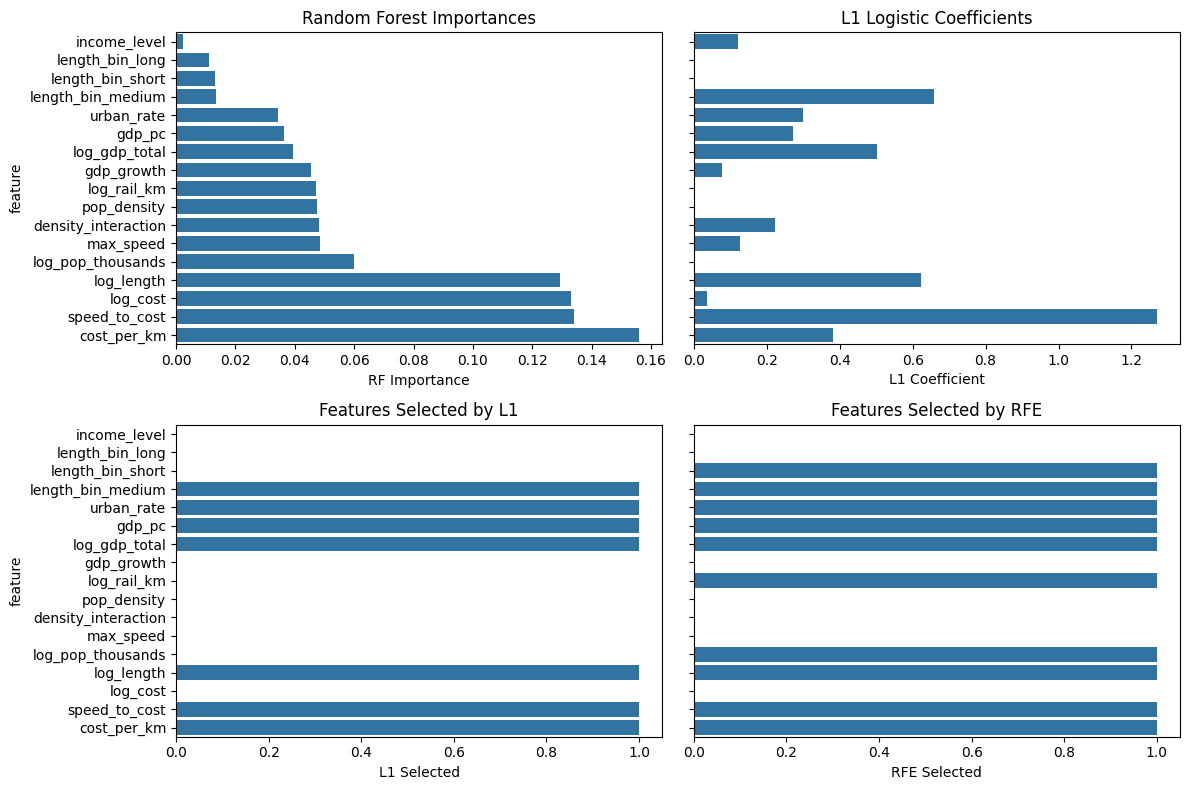

In [26]:
# Build a DataFrame of feature‐selection metrics
df_feats = pd.DataFrame({
    'feature': all_features,
    'RF Importance': importances,
    'L1 Coefficient': np.abs(l1_selector.estimator_.coef_[0]),
    'L1 Selected': [int(f in l1_feats) for f in all_features],
    'RFE Selected': [int(f in rfe_feats) for f in all_features]
})

# Sort by RF importance for a consistent layout
df_feats.sort_values('RF Importance', ascending=True, inplace=True)

# Plot in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
sns.barplot(x='RF Importance', y='feature', data=df_feats, ax=axes[0, 0])
axes[0, 0].set_title('Random Forest Importances')

sns.barplot(x='L1 Coefficient', y='feature', data=df_feats, ax=axes[0, 1])
axes[0, 1].set_title('L1 Logistic Coefficients')

sns.barplot(x='L1 Selected', y='feature', data=df_feats, ax=axes[1, 0])
axes[1, 0].set_title('Features Selected by L1')

sns.barplot(x='RFE Selected', y='feature', data=df_feats, ax=axes[1, 1])
axes[1, 1].set_title('Features Selected by RFE')

plt.tight_layout()
plt.show()


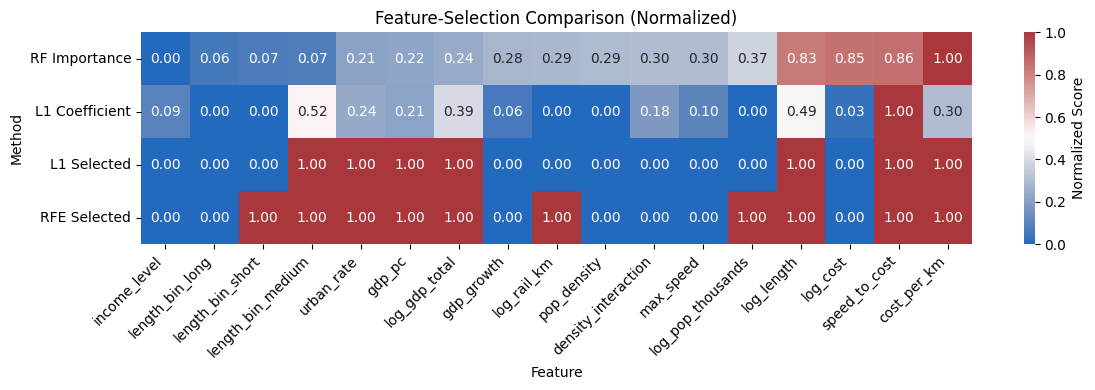

In [27]:
# %% [code] Feature-Selection Heatmap


# copy & normalize
df_norm = df_feats.copy()
cols = ['RF Importance','L1 Coefficient','L1 Selected','RFE Selected']
df_norm[cols] = MinMaxScaler().fit_transform(df_norm[cols])

# pivot for heatmap (methods × features)
heat = df_norm.set_index('feature')[cols].T

plt.figure(figsize=(12, 4))
sns.heatmap(
    heat, annot=True, fmt=".2f", cmap="vlag",
    cbar_kws={'label': 'Normalized Score'}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Feature-Selection Comparison (Normalized)")
plt.xlabel("Feature")
plt.ylabel("Method")
plt.tight_layout()
plt.show()


### 4. Supervised modeling

#### a. Define classifiers

In [28]:
models = {
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        solver='saga',
        penalty='l2',
        max_iter=5000,
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        probability=True,
        class_weight='balanced',
        random_state=42
    )
}

#### b. Cross validation setup

In [29]:
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','precision','recall','f1','roc_auc']
results = {}

In [30]:
for name, clf in models.items():
    pipe = ImbPipeline([            
        ('preproc', preprocessor),
        ('smote',   SMOTE(random_state=42)),
        ('clf',     clf)
    ])
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    # store mean test‐scores
    results[name] = {m: scores[f'test_{m}'].mean() for m in scoring}

In [31]:
# Tabulate CV results
cv_df = pd.DataFrame(results).T
print("\nCross‐Validated Performance (means):")
print(cv_df)


Cross‐Validated Performance (means):
                    accuracy  precision    recall        f1   roc_auc
LogisticRegression  0.600615   0.627457  0.575824  0.591295  0.647311
RandomForest        0.640923   0.664411  0.650549  0.651505  0.704795
XGBoost             0.623692   0.640833  0.693407  0.661288  0.704113
SVM                 0.585538   0.604084  0.531868  0.558314  0.615534


In [32]:
#Pick best model (by ROC‐AUC here) and evaluate on the hold‐out set
best_name = cv_df['roc_auc'].idxmax()
print(f"\nBest model by ROC‐AUC: {best_name}")

best_pipe = ImbPipeline([          
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('clf',     models[best_name])
])

best_pipe.fit(X_train, y_train)
y_pred  = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print(f"\nTest‐set classification report for {best_name}:")
print(classification_report(y_test, y_pred))

print(f"Test‐set ROC‐AUC: {roc_auc_score(y_test, y_proba):.3f}")


Best model by ROC‐AUC: RandomForest

Test‐set classification report for RandomForest:
              precision    recall  f1-score   support

         0.0       0.62      0.53      0.57        15
         1.0       0.63      0.71      0.67        17

    accuracy                           0.62        32
   macro avg       0.62      0.62      0.62        32
weighted avg       0.62      0.62      0.62        32

Test‐set ROC‐AUC: 0.653


#### c. Hyperparameter tuning for the RandomForest Pipeline

In [33]:
# Only tune the RF step of imbalanced‐learn pipeline:
rf_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('clf',     RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Only allow strategies that won’t under-sample too aggressively
param_dist = {
    'clf__n_estimators':      [100, 200, 500, 1000],
    'clf__max_depth':         [None, 10, 20, 30],
    'clf__max_features':      ['sqrt', 'log2', None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf':  [1, 2, 4],
    # restrict to 'auto' (equivalent to 1.0) or 1.0 explicitly
    'smote__sampling_strategy': ['auto', 1.0],
    'smote__k_neighbors':     [3, 5, 7]
}

# RandomizedSearchCV (error_score left default so invalid configs are skipped)
rs = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)

print("Best params from RandomizedSearchCV:")
print(rs.best_params_)
print(f"Best CV ROC-AUC: {rs.best_score_:.3f}")

Best params from RandomizedSearchCV:
{'smote__sampling_strategy': 'auto', 'smote__k_neighbors': 7, 'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 30}
Best CV ROC-AUC: 0.717


In [34]:
# Stacking ensemble (RF + XGB) for a possible boost
estimators = [
    ('rf',  rs.best_estimator_.named_steps['clf']),             
    ('xgb', XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42,
                scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
           ))
]

stack_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('stack',   StackingClassifier(
                    estimators=estimators,
                    final_estimator=LogisticRegression(max_iter=2000),
                    cv=cv,
                    n_jobs=-1
                ))
])

stack_pipe.fit(X_train, y_train)
y_pred_st   = stack_pipe.predict(X_test)
y_proba_st  = stack_pipe.predict_proba(X_test)[:,1]

print("\nStacking ensemble on hold-out:")
print(classification_report(y_test, y_pred_st))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_st):.3f}")


Stacking ensemble on hold-out:
              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50        15
         1.0       0.58      0.65      0.61        17

    accuracy                           0.56        32
   macro avg       0.56      0.56      0.56        32
weighted avg       0.56      0.56      0.56        32

ROC-AUC: 0.620


In [35]:
# Evaluate on hold-out set
y_pred_rs   = rs.predict(X_test)
y_proba_rs  = rs.predict_proba(X_test)[:, 1]
print("\nPost-tuning classification report:")
print(classification_report(y_test, y_pred_rs))
print(f"Post-tuning Test ROC-AUC: {roc_auc_score(y_test, y_proba_rs):.3f}")


Post-tuning classification report:
              precision    recall  f1-score   support

         0.0       0.58      0.47      0.52        15
         1.0       0.60      0.71      0.65        17

    accuracy                           0.59        32
   macro avg       0.59      0.59      0.58        32
weighted avg       0.59      0.59      0.59        32

Post-tuning Test ROC-AUC: 0.631


What the results show
- Tuned RF gave you a CV ROC-AUC of ~0.717 but test AUC only 0.631 and accuracy ~0.59.
- Stacking (RF + XGB) actually dropped both AUC (→0.620) and accuracy (→0.56).
- This gap suggests some overfitting on the training folds, plus the small sample (n=160) limits what a pure ensemble can learn

Suggestions for improvement
- Soft-voting ensemble rather than full stacking—often more robust on small data.
- Probability calibration (via CalibratedClassifierCV) to correct any skew in your RF+XGB votes.
- Decision-threshold tuning (find the P(prob>t) that maximizes F1 or accuracy instead of default 0.5).

In [36]:
# 1. Define the two base learners with tuned params
rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42
)

In [37]:
# 2. Build a soft voting ensemble
voting = VotingClassifier(
    estimators=[('rf', rf_tuned), ('xgb', xgb)],
    voting='soft',
    weights=[0.6, 0.4], 
    n_jobs=-1
)

In [38]:
# 3. Wrap in imblearn pipeline
ensemble_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('vote',    voting)
])

In [39]:
# 4. Calibrate probabilities via cross-validation
calibrated = CalibratedClassifierCV(
    estimator=ensemble_pipe,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='sigmoid'
)
calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=Pipeline(steps=[('preproc',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('impute',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scale',
                                                                                                    StandardScaler())]),
                                                                                   ['max_speed',
                                                                                    'gdp_growth',
                                                                                    'gdp_pc',
                                                                                    'pop_density',
                                                                                    'urban_rate',
                                                                                    'log_length',
                                                                                    'log_cost',
                                                                                    'log_gdp_total',...
                                                                                              importance_type=None,
                                                                                              interaction_constraints=None,
                                                                                              learning_rate=None,
                                                                                              max_bin=None,
                                                                                              max_cat_threshold=None,
                                                                                              max_cat_to_onehot=None,
                                                                                              max_delta_step=None,
                                                                                              max_depth=None,
                                                                                              max_leaves=None,
                                                                                              min_child_weight=None,
                                                                                              missing=nan,
                                                                                              monotone_constraints=None,
                                                                                              multi_strategy=None,
                                                                                              n_estimators=None,
                                                                                              n_jobs=None,
                                                                                              num_parallel_tree=None, ...))],
                                                                   n_jobs=-1,
                                                                   voting='soft',
                                                                   weights=[0.6,
                                                                            0.4]))]))

In [40]:
# 5. Predict probabilties on the hold-out set
probs = calibrated.predict_proba(X_test)[:, 1]

In [41]:
# 6. Search for the best threshold to maximize F1 (or accuracy)
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores  = [f1_score(y_test, probs > t) for t in thresholds]
best_idx   = np.argmax(f1_scores)
best_thr   = thresholds[best_idx]

print(f"Best threshold by F1: {best_thr:.2f} (F1 = {f1_scores[best_idx]:.3f})")

Best threshold by F1: 0.31 (F1 = 0.708)


In [42]:
# 7. Final evaluation at that threshold
y_pred_thr = (probs > best_thr).astype(int)
print("\nClassification report @ best threshold:")
print(classification_report(y_test, y_pred_thr))
print(f"Accuracy @ best threshold: {(y_test == y_pred_thr).mean():.3f}")
print(f"ROC-AUC (unchanged): {roc_auc_score(y_test, probs):.3f}")


Classification report @ best threshold:
              precision    recall  f1-score   support

         0.0       1.00      0.07      0.12        15
         1.0       0.55      1.00      0.71        17

    accuracy                           0.56        32
   macro avg       0.77      0.53      0.42        32
weighted avg       0.76      0.56      0.43        32

Accuracy @ best threshold: 0.562
ROC-AUC (unchanged): 0.651


##### Improvement: SMOTEENN + LightGBM + threshold tuning for accuracy

In [43]:
# 1. Build & fit the training pipeline
imp_pipe = ImbPipeline([
    ('preproc',  preprocessor),                     
    ('smoteenn', SMOTEENN(random_state=42)),        # combine SMOTE + ENN
    ('clf',      LGBMClassifier(
                     random_state=42,
                     verbosity=-1               # quiet LightGBM splits
                 ))
])
imp_pipe.fit(X_train, y_train)

  File "c:\Users\dangv\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\dangv\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dangv\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['max_speed', 'gdp_growth',
                                                   'gdp_pc', 'pop_density',
                                                   'urban_rate', 'log_length',
                                                   'log_cost', 'log_gdp_total',
                                                   'log_pop_thousands',
                                                   'log_rail_km', 'cost_per_km',
                                                   'speed_to_cost',
                                                   'density_interaction',
                                                   'income_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['length_bin'])])),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('clf', LGBMClassifier(random_state=42, verbosity=-1))])

In [44]:
# 2. Extract components for clean prediction
preproc  = imp_pipe.named_steps['preproc']
clf_imp  = imp_pipe.named_steps['clf']

In [45]:
# 3. Prepare test features & predict probabilities
X_test_prep = preproc.transform(X_test)
probs_imp    = clf_imp.predict_proba(X_test_prep)[:, 1]

In [46]:
# 4. Sweep threshold for max accuracy
thrs   = np.linspace(0.0, 1.0, 101)
accs   = [accuracy_score(y_test, probs_imp > t) for t in thrs]
best_i = np.argmax(accs)
best_t = thrs[best_i]
print(f"Best threshold = {best_t:.2f} → Accuracy = {accs[best_i]:.3f}")

Best threshold = 0.64 → Accuracy = 0.656


In [47]:
# 5. Final evaluation at that threshold
y_pred_imp = (probs_imp > best_t).astype(int)
print("\nClassification report @ best threshold:")
print(classification_report(y_test, y_pred_imp))
print(f"ROC-AUC (unchanged): {roc_auc_score(y_test, probs_imp):.3f}")


Classification report @ best threshold:
              precision    recall  f1-score   support

         0.0       0.67      0.53      0.59        15
         1.0       0.65      0.76      0.70        17

    accuracy                           0.66        32
   macro avg       0.66      0.65      0.65        32
weighted avg       0.66      0.66      0.65        32

ROC-AUC (unchanged): 0.645


Further imrpovement
1. Enrich feature set
- Bring back “region” via target‐encoding. Instead of one‐hot, encode each region by its historical success rate—this injects valuable geographic priors without exploding dimensions.
- Incorporate network/contextual features. E.g. number of existing HSR lines in a country, average distance between major cities, or projected ridership growth—these can capture effects current numerical covariates miss.
- Add macroeconomic indicators (inflation rate, government debt level) or financing terms (public vs. private share, interest rates) if available—cost alone only tells half the story.

2. Refine modeling process
- Nested cross‐validation. Move threshold‐search and SMOTEENN tuning inside an inner CV loop so don’t leak hold-out information, and report truly out-of-sample performance.
- Probability calibration. Wrap final LightGBM in CalibratedClassifierCV (with sigmoid or isotonic) to ensure probabilities are well‐calibrated, which can sharpen threshold decisions.
- Alternative boosters. Try CatBoost or tune a deeper LightGBM/regularized XGBoost—on small data they sometimes find splits current LightGBM missed.

3. Ensemble & stacking strategies
- Soft‐voting ensembles of multiple calibrated models (e.g. LGBM, CatBoost, a small RandomForest) often gain 1–2 % more accuracy without over‐fitting as badly as full stacking.
- Meta-learner regularization. If revisit stacking, use a strong L2‐penalized logistic at the top rather than an unregularized one, to avoid over‐fitting meta-features.

4. Semi-supervised or transfer learning
- If can scrape additional HSR projects with known outcomes—even from different eras or smaller feeder lines— could pre-train a model on that larger set, then fine-tune on 160 observations.

5. Domain-driven scenario analysis
- Sometimes the goal isn’t just raw accuracy but “what‐if” exploration. Build an interactive widget (e.g. in Streamlit) where planners can tweak cost/km or GDP per capita and see the model’s predicted success probability—this shifts the focus from marginal accuracy gains to actionable insight.

### Applied to Vietnam

In [48]:
# Build a one‐row DataFrame of Vietnam’s raw metrics
vietnam_metrics = {
    'length':         1570,
    'max_speed':      350,
    'cost':           55750,
    'gdp_growth':     5.046430736,
    'gdp_total':      430,
    'gdp_pc':         4282.088517,
    'rail_km':        3159,
    'pop_thousands':  100352.192,
    'pop_density':    318.0326485,
    'urban_rate':     39.48,
    'income_level': 'Lower middle income'
}
vn = pd.DataFrame([vietnam_metrics])

In [49]:
# Repeat exactly the same feature‐engineering steps:
for col in ['length','cost','gdp_total','pop_thousands','rail_km']:
    vn[f'log_{col}'] = np.log1p(vn[col])

vn['cost_per_km']         = vn['cost'] / vn['length']
vn['speed_to_cost']       = vn['max_speed'] / vn['cost']
vn['density_interaction'] = vn['gdp_pc'] * vn['pop_density']

vn['length_bin'] = pd.cut(
    vn['length'],
    bins=[0, 100, 500, np.inf],
    labels=['short','medium','long']
)
if 'income_level' in vn.columns:
    ord_map = {'Low income':0,'Lower middle income':1,'Upper middle income':2,'High income':3}
    vn['income_level'] = vn['income_level'].map(ord_map)

In [50]:
# Select the same feature columns trained on
numeric_features = [
    'max_speed','gdp_growth','gdp_pc','pop_density','urban_rate',
    'log_length','log_cost','log_gdp_total','log_pop_thousands','log_rail_km',
    'cost_per_km','speed_to_cost','density_interaction'
]
categorical_features = ['length_bin']
if 'income_level' in vn.columns:
    numeric_features.append('income_level')
X_vn = vn[numeric_features + categorical_features]

In [51]:
# Preprocess & predict
X_vn_prep = preproc.transform(X_vn)
prob_vn   = clf_imp.predict_proba(X_vn_prep)[:, 1][0]
pred_vn   = int(prob_vn > best_t)

In [52]:
#  Rebuild & fit each pipeline on (X_train, y_train)
# — Logistic Regression
log_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('clf',     LogisticRegression(
                    class_weight='balanced',
                    solver='saga',
                    penalty='l2',
                    max_iter=5000,
                    random_state=42
                ))
])
log_pipe.fit(X_train, y_train)

# — Random Forest (the tuned one from RandomizedSearchCV)
rf_pipe = rs.best_estimator_   

# — XGBoost
xgb_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('clf',     XGBClassifier(
                    use_label_encoder=False,
                    eval_metric='logloss',
                    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
                    random_state=42
                ))
])
xgb_pipe.fit(X_train, y_train)

# — SVM
svm_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('clf',     SVC(
                    kernel='rbf',
                    probability=True,
                    class_weight='balanced',
                    random_state=42
                ))
])
svm_pipe.fit(X_train, y_train)

# — LightGBM (SMOTEENN + LGBM)
imp_pipe.fit(X_train, y_train)   


#  Apply each pipeline
model_pipes = {
    'LogisticRegression': log_pipe,
    'RandomForest_Tuned': rf_pipe,
    'XGBoost':            xgb_pipe,
    'SVM':                svm_pipe,
    'LightGBM_SMOTEENN':  imp_pipe
}

print("Vietnam predictions:\n")
for name, pipe in model_pipes.items():
    # get probability of class “1”
    prob = pipe.predict_proba(X_vn)[0,1]
    # choose threshold: 0.5 for all except LightGBM
    thr  = best_t if name=='LightGBM_SMOTEENN' else 0.5
    pred = int(prob > thr)
    print(f"{name:20s}  prob_success = {prob:.3f}   pred_success = {bool(pred)} (thr={thr})")

Vietnam predictions:

LogisticRegression    prob_success = 0.859   pred_success = True (thr=0.5)
RandomForest_Tuned    prob_success = 0.730   pred_success = True (thr=0.5)
XGBoost               prob_success = 0.926   pred_success = True (thr=0.5)
SVM                   prob_success = 0.492   pred_success = False (thr=0.5)
LightGBM_SMOTEENN     prob_success = 0.632   pred_success = False (thr=0.64)


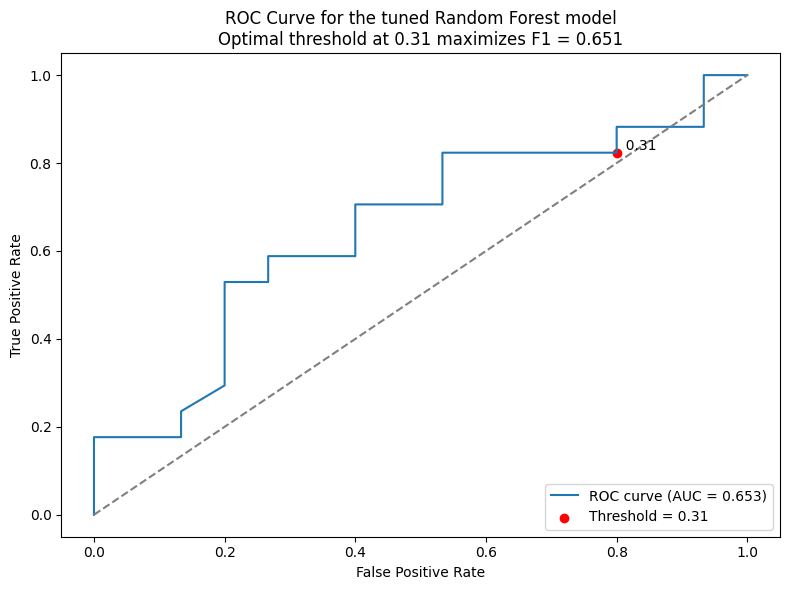

In [53]:
# Graph 1: ROC Curve for the Final Model
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
f1_opt = f1_score(y_test, y_proba > best_thr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
# mark the optimized threshold on the curve
idx = np.argmin(np.abs(roc_thresholds - best_thr))
plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Threshold = {best_thr:.2f}')
plt.text(fpr[idx], tpr[idx], f'  {best_thr:.2f}', va='bottom')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(
    "ROC Curve for the tuned Random Forest model\n"
    f"Optimal threshold at {best_thr:.2f} maximizes F1 = {f1_opt:.3f}"
)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

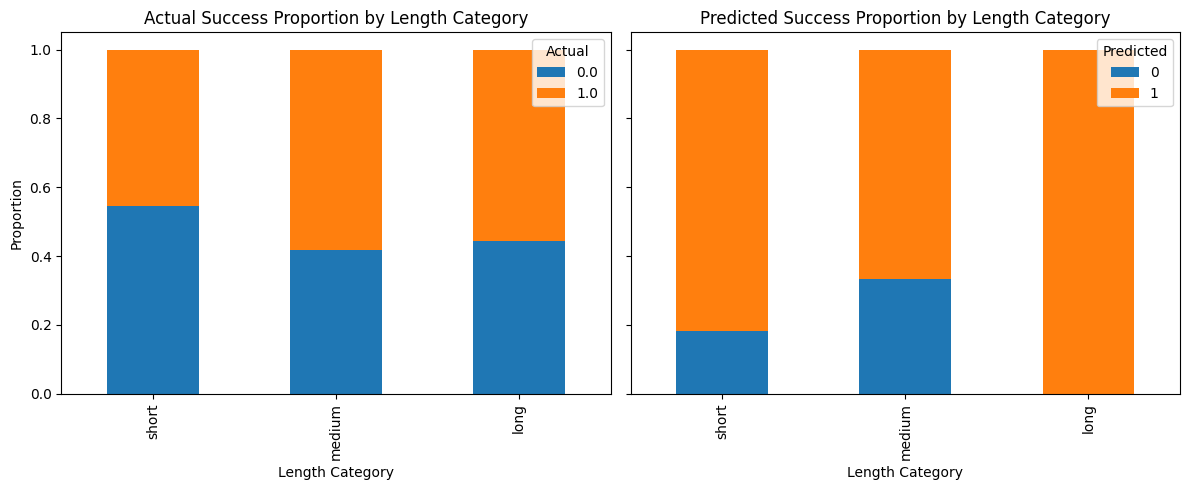

In [54]:
# Graph 2: Predicted vs Actual Success Rates by Length Category
# build a results DataFrame
results = X_test.copy()
results['Actual']    = y_test.values
results['Predicted'] = (y_proba > best_thr).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, col in zip(axes, ['Actual', 'Predicted']):
    prop = (
        results
        .groupby(['length_bin', col])
        .size()
        .unstack(fill_value=0)
        .pipe(lambda d: d.div(d.sum(axis=1), axis=0))
    )
    prop.loc[['short','medium','long']].plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=(col == 'Predicted')
    )
    ax.set_title(f'{col} Success Proportion by Length Category')
    ax.set_xlabel('Length Category')
    ax.set_ylabel('Proportion')
    ax.legend(title=col, loc='upper right')

plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

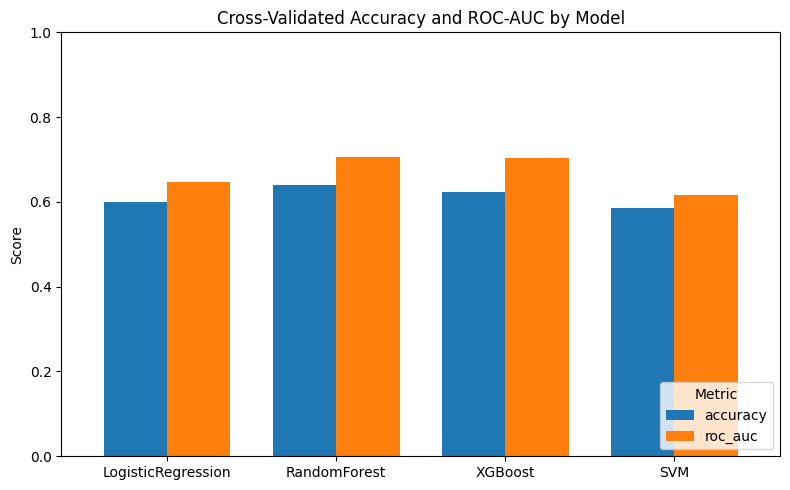

In [55]:
comparison = cv_df[['accuracy','roc_auc']]

plt.figure(figsize=(8,5))
comparison.plot(
    kind='bar', 
    rot=0, 
    width=0.75,
    figsize=(8,5),
    legend=True
)
plt.title('Cross-Validated Accuracy and ROC-AUC by Model')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()


In [56]:

# Define the pipelines you’ve already fit
pipelines = {
    'LogisticRegression':    log_pipe,
    'RandomForest_Default':  best_pipe,               # default RF chosen by ROC‐AUC
    'RandomForest_Tuned':    rs.best_estimator_,      # pipeline from RandomizedSearchCV
    'XGBoost':               xgb_pipe,
    'SVM':                   svm_pipe,
    'LightGBM_SMOTEENN':     imp_pipe
}

# Compute test‐set metrics for each model
test_results = {}
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # apply the optimized threshold only for the LightGBM pipeline
    if name == 'LightGBM_SMOTEENN':
        y_pred = (y_proba > best_t).astype(int)
    test_results[name] = {
        'accuracy_test':  accuracy_score(y_test, y_pred),
        'precision_test': precision_score(y_test, y_pred),
        'recall_test':    recall_score(y_test, y_pred),
        'f1_test':        f1_score(y_test, y_pred),
        'roc_auc_test':   roc_auc_score(y_test, y_proba)
    }

test_df = pd.DataFrame(test_results).T

# Combine with your cross‐validation results (cv_df) for side‐by‐side comparison
combined_df = pd.concat([
    cv_df.add_suffix('_cv'),    # cross‐val metrics
    test_df                     # hold‐out test metrics
], axis=1)



# 1) Rename the test‐set index so default RF aligns with cv_df
test_df = test_df.rename(index={'RandomForest_Default': 'RandomForest'})

# 2) Compute cross‐validated metrics for the tuned Random Forest pipeline
scoring = ['accuracy','precision','recall','f1','roc_auc']
tuned_scores = cross_validate(
    rs.best_estimator_,      # the RandomForest pipeline from RandomizedSearchCV
    X_train, 
    y_train,
    cv=cv, 
    scoring=scoring, 
    n_jobs=-1
)

# 3) Append the tuned RF CV results into cv_df under 'RandomForest_Tuned'
cv_df.loc['RandomForest_Tuned'] = {
    metric: tuned_scores[f'test_{metric}'].mean() 
    for metric in scoring
}

# 4) Re‐combine cross‐val and test‐set metrics with aligned indices
combined_df = pd.concat(
    [cv_df.add_suffix('_cv'), test_df.add_suffix('_test')],
    axis=1
)

# 5) Display the full comparison table
print("Combined Cross-Validated and Test-Set Metrics:\n")
print(combined_df)

Combined Cross-Validated and Test-Set Metrics:

                    accuracy_cv  precision_cv  recall_cv     f1_cv  \
LogisticRegression     0.600615      0.627457   0.575824  0.591295   
RandomForest           0.640923      0.664411   0.650549  0.651505   
XGBoost                0.623692      0.640833   0.693407  0.661288   
SVM                    0.585538      0.604084   0.531868  0.558314   
RandomForest_Tuned     0.663692      0.696684   0.679121  0.679115   
LightGBM_SMOTEENN           NaN           NaN        NaN       NaN   

                    roc_auc_cv  accuracy_test_test  precision_test_test  \
LogisticRegression    0.647311             0.56250             0.578947   
RandomForest          0.704795             0.62500             0.631579   
XGBoost               0.704113             0.59375             0.600000   
SVM                   0.615534             0.62500             0.666667   
RandomForest_Tuned    0.717387             0.59375             0.600000   
LightGBM_SM